In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import lasagne
import numpy as np
import pickle
import skimage.transform
import scipy

import theano
import theano.tensor as T

from lasagne.utils import floatX

import matplotlib.pyplot as plt
from IPython import display

In [4]:
# VGG-19, 19-layer model from the paper:
# "Very Deep Convolutional Networks for Large-Scale Image Recognition"
# Original source: https://gist.github.com/ksimonyan/3785162f95cd2d5fee77
# License: non-commercial use only

from lasagne.layers import InputLayer, DenseLayer, NonlinearityLayer
from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.nonlinearities import softmax, rectify

IMAGE_W = 600

# Note: tweaked to use average pooling instead of maxpooling
def build_model():
    net = {}
    net['input'] = InputLayer((1, 3, IMAGE_W, IMAGE_W))
    net['conv1_1'] = ConvLayer(net['input'], 64, 3, pad=1, flip_filters=False)
    net['conv1_2'] = ConvLayer(net['conv1_1'], 64, 3, pad=1, flip_filters=False)
    net['pool1'] = PoolLayer(net['conv1_2'], 2, mode='average_exc_pad')
    net['conv2_1'] = ConvLayer(net['pool1'], 128, 3, pad=1, flip_filters=False)
    net['conv2_2'] = ConvLayer(net['conv2_1'], 128, 3, pad=1, flip_filters=False)
    net['pool2'] = PoolLayer(net['conv2_2'], 2, mode='average_exc_pad')
    net['conv3_1'] = ConvLayer(net['pool2'], 256, 3, pad=1, flip_filters=False)
    net['conv3_2'] = ConvLayer(net['conv3_1'], 256, 3, pad=1, flip_filters=False)
    net['conv3_3'] = ConvLayer(net['conv3_2'], 256, 3, pad=1, flip_filters=False)
    net['conv3_4'] = ConvLayer(net['conv3_3'], 256, 3, pad=1, flip_filters=False)
    net['pool3'] = PoolLayer(net['conv3_4'], 2, mode='average_exc_pad')
    net['conv4_1'] = ConvLayer(net['pool3'], 512, 3, pad=1, flip_filters=False)
    net['conv4_2'] = ConvLayer(net['conv4_1'], 512, 3, pad=1, flip_filters=False)
    net['conv4_3'] = ConvLayer(net['conv4_2'], 512, 3, pad=1, flip_filters=False)
    net['conv4_4'] = ConvLayer(net['conv4_3'], 512, 3, pad=1, flip_filters=False)
    net['pool4'] = PoolLayer(net['conv4_4'], 2, mode='average_exc_pad')
    net['conv5_1'] = ConvLayer(net['pool4'], 512, 3, pad=1, flip_filters=False)
    net['conv5_2'] = ConvLayer(net['conv5_1'], 512, 3, pad=1, flip_filters=False)
    net['conv5_3'] = ConvLayer(net['conv5_2'], 512, 3, pad=1, flip_filters=False)
    net['conv5_4'] = ConvLayer(net['conv5_3'], 512, 3, pad=1, flip_filters=False)
    net['pool5'] = PoolLayer(net['conv5_4'], 2, mode='average_exc_pad')

    return net

In [5]:
# build VGG net and load weights

net = build_model()

values = pickle.load(open('vgg19_normalized.pkl'))['param values']
lasagne.layers.set_all_param_values(net['pool5'], values)

In [6]:
MEAN_VALUES = np.array([104, 117, 123]).reshape((3,1,1))

def prep_image(im):
    if len(im.shape) == 2:
        im = im[:, :, np.newaxis]
        im = np.repeat(im, 3, axis=2)
    h, w, _ = im.shape
    if h < w:
        im = skimage.transform.resize(im, (IMAGE_W, w*IMAGE_W/h), preserve_range=True)
    else:
        im = skimage.transform.resize(im, (h*IMAGE_W/w, IMAGE_W), preserve_range=True)

    # Central crop
    h, w, _ = im.shape
    im = im[h//2-IMAGE_W//2:h//2+IMAGE_W//2, w//2-IMAGE_W//2:w//2+IMAGE_W//2]
    
    rawim = np.copy(im).astype('uint8')
    
    # Shuffle axes to c01
    im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)
    
    # Convert RGB to BGR
    im = im[::-1, :, :]

    im = im - MEAN_VALUES
    return rawim, floatX(im[np.newaxis])

def deprocess(x):
    x = np.copy(x[0])
    x += MEAN_VALUES

    x = x[::-1]
    x = np.swapaxes(np.swapaxes(x, 0, 1), 1, 2)
    
    x = np.clip(x, 0, 255).astype('uint8')
    return x

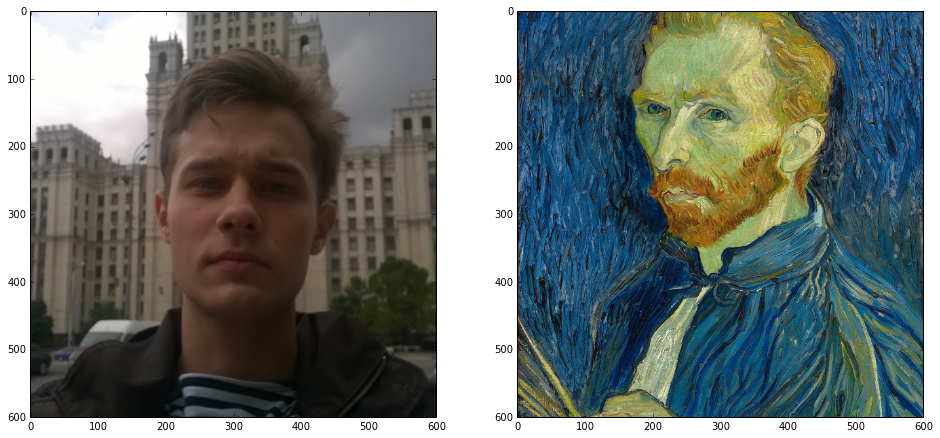

In [9]:
figsize(16,8)
photo = plt.imread('WP_20140817_14_48_41_Pro.jpg')
rawim, photo = prep_image(photo)
plt.subplot(121)
plt.imshow(rawim)

plt.subplot(122)
# art = plt.imread('texture_140_by_sirius_sdz-d2btip9.jpg')
art = plt.imread('1024px-Vincent_van_Gogh_-_Self-Portrait_-_Google_Art_Project_(719161).jpg')
rawim, art = prep_image(art)
plt.imshow(rawim)

In [10]:
def gram_matrix(x):
    x = x.flatten(ndim=3)
    g = T.tensordot(x, x, axes=([2], [2]))
    return g


def content_loss(P, X, layer):
    p = P[layer]
    x = X[layer]
    
    loss = 1./2 * ((x - p)**2).sum()
    return loss


def style_loss(A, X, layer):
    a = A[layer]
    x = X[layer]
    
    A = gram_matrix(a)
    G = gram_matrix(x)
    
    N = a.shape[1]
    M = a.shape[2] * a.shape[3]
    
    loss = 1./(4 * N**2 * M**2) * ((G - A)**2).sum()
    return loss

def total_variation_loss(x):
    return (((x[:,:,:-1,:-1] - x[:,:,1:,:-1])**2 + (x[:,:,:-1,:-1] - x[:,:,:-1,1:])**2)**1.25).sum()

In [11]:
layers = ['conv4_2', 'conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
layers = {k: net[k] for k in layers}

input_im_theano = T.tensor4()
generated_image = theano.shared(floatX(np.random.uniform(-128, 128, (1, 3, IMAGE_W, IMAGE_W))))

outputs = lasagne.layers.get_output(layers.values(), input_im_theano)

photo_features = {k: theano.shared(output.eval({input_im_theano: photo}))
                  for k, output in zip(layers.keys(), outputs)}
art_features = {k: theano.shared(output.eval({input_im_theano: art}))
                for k, output in zip(layers.keys(), outputs)}

gen_features = lasagne.layers.get_output(layers.values(), generated_image)
gen_features = {k: v for k, v in zip(layers.keys(), gen_features)}

In [12]:
def make_discriminator(art_features, layer):
    spatial_softmax = theano.sandbox.cuda.dnn.GpuDnnSoftmax(tensor_format='bc01', algo='accurate', mode='channel')
    disc = {}
    disc['input'] = InputLayer(art_features[layer].get_value().shape)
    disc['conv_1'] = ConvLayer(disc['input'], 
                               filter_size=1, num_filters=256, flip_filters=False, 
                               nonlinearity=rectify)
    disc['conv_2'] = ConvLayer(disc['conv_1'], 
                               filter_size=1, num_filters=128, flip_filters=False, 
                               nonlinearity=rectify)
    disc['conv_3'] = ConvLayer(disc['conv_2'], 
                               filter_size=1, num_filters=2, flip_filters=False, 
                               nonlinearity=spatial_softmax)
    disc['output'] = disc['conv_3']
    disc['weights'] = lasagne.layers.get_all_params(disc['output'])
    disc['weights_dump'] = [w.get_value() for w in disc['weights']]
    return disc

def reinit_disc(disc):
    for w, d in zip(disc['weights'], disc['weights_dump']):
        w.set_value(d)

In [13]:
discriminators = {l: make_discriminator(art_features, l) for l in art_features}
art_preds = {l: lasagne.layers.get_output(discriminators[l]['output'], art_features[l]) for l in layers}
gen_preds = {l: lasagne.layers.get_output(discriminators[l]['output'], gen_features[l]) for l in layers}

disc_loss = []
disc_loss.append(T.mean(-T.log(art_preds['conv1_1'][0, 1, :, :])))
disc_loss.append(T.mean(-T.log(art_preds['conv2_1'][0, 1, :, :])))
disc_loss.append(T.mean(-T.log(art_preds['conv3_1'][0, 1, :, :])))
disc_loss.append(T.mean(-T.log(art_preds['conv4_1'][0, 1, :, :])))
disc_loss.append(T.mean(-T.log(art_preds['conv5_1'][0, 1, :, :])))

disc_loss.append(T.mean(-T.log(gen_preds['conv1_1'][0, 0, :, :])))
disc_loss.append(T.mean(-T.log(gen_preds['conv2_1'][0, 0, :, :])))
disc_loss.append(T.mean(-T.log(gen_preds['conv3_1'][0, 0, :, :])))
disc_loss.append(T.mean(-T.log(gen_preds['conv4_1'][0, 0, :, :])))
disc_loss.append(T.mean(-T.log(gen_preds['conv5_1'][0, 0, :, :])))

disc_loss = T.sum(disc_loss)

In [14]:
params = []
params.extend(discriminators['conv1_1']['weights'])
params.extend(discriminators['conv2_1']['weights'])
params.extend(discriminators['conv3_1']['weights'])
params.extend(discriminators['conv4_1']['weights'])
params.extend(discriminators['conv5_1']['weights'])

disc_adam = lasagne.updates.adam(disc_loss, params)
train_discs = theano.function([], [disc_loss], updates=disc_adam)

In [15]:
def get_image_loss(content_w, texture_w, variation_w):
    image_loss = []

    image_loss.append(content_w * content_loss(photo_features, gen_features, 'conv4_2'))

    image_loss.append(texture_w * T.mean(-T.log(gen_preds['conv1_1'][0, 1, :, :])))
    image_loss.append(texture_w * T.mean(-T.log(gen_preds['conv2_1'][0, 1, :, :])))
    image_loss.append(texture_w * T.mean(-T.log(gen_preds['conv3_1'][0, 1, :, :])))
    image_loss.append(texture_w * T.mean(-T.log(gen_preds['conv4_1'][0, 1, :, :])))
    image_loss.append(texture_w * T.mean(-T.log(gen_preds['conv5_1'][0, 1, :, :])))

    image_loss.append(variation_w * total_variation_loss(generated_image))

    image_loss = T.sum(image_loss)
    return image_loss

## Возьмём в качестве начального приближения фотографию вместо шума

In [16]:
[reinit_disc(discriminators[l]) for l in layers]
generated_image.set_value(photo)
image_loss = get_image_loss(1e-3, 1e2, 1e-7)
image_adam = lasagne.updates.adam(image_loss, [generated_image], learning_rate=1.0)
update_image = theano.function([], [image_loss], updates=image_adam)

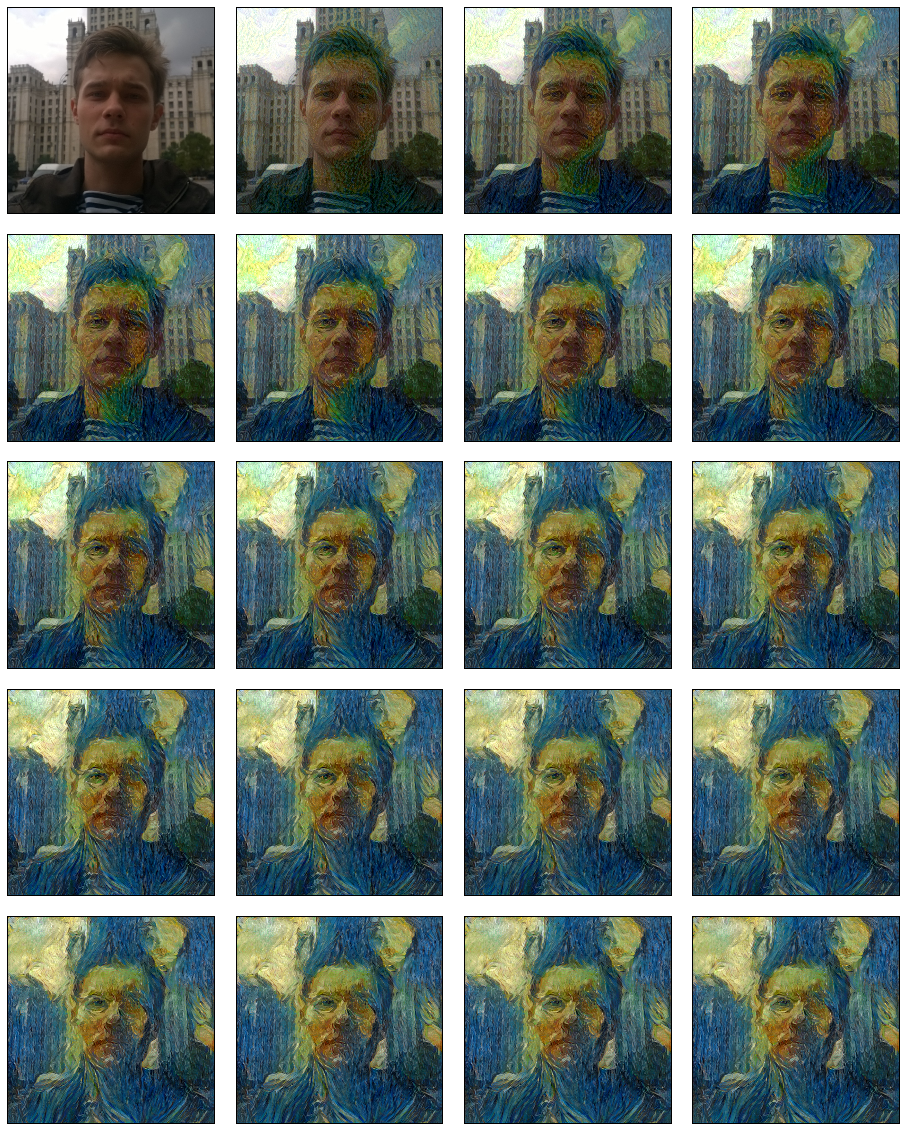

In [17]:
fig, axs = plt.subplots(5,4, figsize=(16, 20), facecolor='w', edgecolor='w')
fig.subplots_adjust(hspace = .1, wspace=.1)
axs = axs.ravel()
[a.xaxis.set_visible(False) for a in axs]
[a.yaxis.set_visible(False) for a in axs]

h_disc_loss = []
h_image_loss = []
images = []
for epoch in range(2000):
    if epoch % 2 == 0:
        h_disc_loss.append(train_discs())
    else:
        h_image_loss.append(update_image())
    if epoch % 100 == 0:
        images.append(generated_image.get_value())
        for i in range(epoch / 100 + 1):
            axs[i].imshow(deprocess(images[i]))
        display.clear_output(wait=True)
        display.display(plt.gcf())
plt.clf()

#### Получаются прикольные изображения

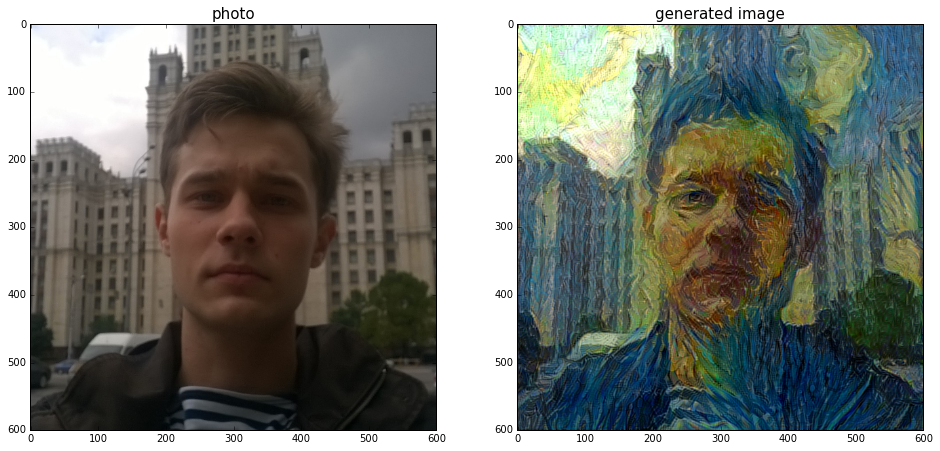

In [18]:
figsize(16,8)

plt.subplot(121)
plt.title('photo', size=15)
plt.imshow(deprocess(photo))

plt.subplot(122)
plt.title('generated image', size=15)
plt.imshow(deprocess(images[6]))

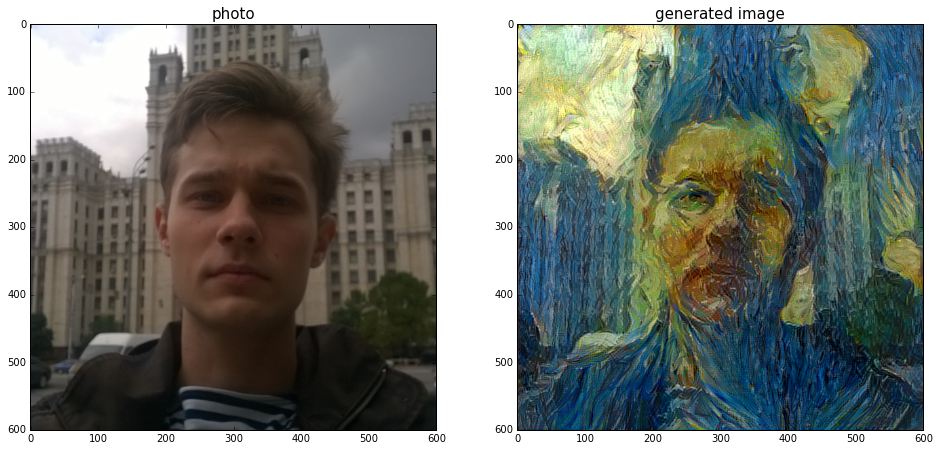

In [19]:
figsize(16,8)

plt.subplot(121)
plt.title('photo', size=15)
plt.imshow(deprocess(photo))

plt.subplot(122)
plt.title('generated image', size=15)
plt.imshow(deprocess(images[11]))

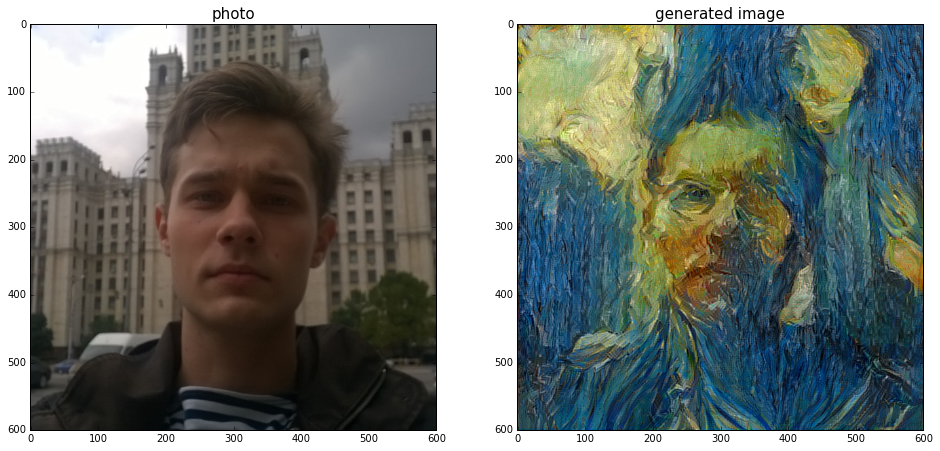

In [21]:
figsize(16,8)

plt.subplot(121)
plt.title('photo', size=15)
plt.imshow(deprocess(photo))

plt.subplot(122)
plt.title('generated image', size=15)
plt.imshow(deprocess(generated_image.get_value()))